In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *

In [5]:
base_path = './data/'

labels = np.load(base_path+'/labels.npy')
test_idxs = np.load(base_path+'/indices.npy')
split_idxs = np.load(base_path+'/IWCD_mPMT_Short_2_class_idxs_xps.npz')

modes = ['Q+T', 'Q', 'Qu', 'Qu+Tu', 'T', 'Qs', 'Qs+Ts', 'Q+Ts', 'Quo']

In [6]:
splitting = {}
for file in split_idxs.files:
    splitting[file]= split_idxs[file]

n_test = len(splitting['test_idxs'])
n_val = len(splitting['val_idxs'])
n_train = len(splitting['train_idxs'])

n_total = n_train + n_val + n_test

print('Total num. of events: ', n_total)
print('Events for testing: %1.3f' % (n_test/n_total*100))
print('Events for validation: %1.3f' % (n_val/n_total*100))
print('Events for training: %1.3f' % (n_train/n_total*100))

Total num. of events:  2950284
Events for testing: 10.004
Events for validation: 2.399
Events for training: 87.596


In [90]:
def basic_metrics(labels, mode):
    
    pred = np.load(base_path + mode + '/predictions.npy')
    prob = np.load(base_path + mode + '/softmax.npy')
    
    fpr, tpr, thresholds = roc_curve(labels, prob[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    metrics = {
        'model': mode,
        'acc': accuracy_score(labels, pred),
        'f1': f1_score(labels, pred),
        'log_loss':  log_loss(labels, prob),
        'auc': roc_auc,
        'opt_threshold': optimal_threshold
    }
    return metrics        

In [91]:
results = []
for mode in modes:
    results.append(basic_metrics(labels,mode))

In [92]:
pd.set_option("display.precision", 4)
df = pd.DataFrame(results)

df['charge'] = np.where(df['model'].str.contains('Q'), 1, 0)
df['time'] = np.where(df['model'].str.contains('T'), 1, 0)
df['scaled'] = np.where(df['model'].str.contains('u'), 0, 1)
df['collapsed'] = np.where(df['model'].str.contains('s'), 1, 0)

df['total_score'] = df.acc+df.f1+df.auc-df.log_loss

df.sort_values(by='total_score', inplace=True, ascending=False)
df = df[['model','charge', 'time', 'scaled', 'collapsed', 'log_loss', 'acc', 'f1', 'auc', 'opt_threshold', 'total_score']].reset_index(drop=True)

df.head(len(modes))

,model,charge,time,scaled,collapsed,log_loss,acc,f1,auc,opt_threshold,total_score
0,Quo,1,0,0,0,0.5940,0.6747,0.6579,0.7434,0.4833,1.4820
1,Q+Ts,1,1,1,1,0.6047,0.6696,0.6613,0.7327,0.4960,1.4590
2,Qs+Ts,1,1,1,1,0.6046,0.6712,0.6542,0.7337,0.4879,1.4546
3,Q+T,1,1,1,0,0.6105,0.6638,0.6488,0.7249,0.5029,1.4270
4,T,0,1,1,0,0.6304,0.6428,0.6308,0.6962,0.5042,1.3394
5,Qu,1,0,0,0,0.6271,0.6427,0.6203,0.7007,0.4866,1.3367
6,Q,1,0,1,0,0.6358,0.6313,0.6142,0.6862,0.4870,1.2959
7,Qs,1,0,1,1,0.6466,0.6186,0.6006,0.6680,0.4923,1.2406
8,Qu+Tu,1,1,0,0,0.6646,0.5906,0.5801,0.6295,0.5076,1.1355


In [132]:
models_to_roc = ['Quo', 'Q+Ts', 'Qs+Ts', 'Q+T', 'Qu']

In [164]:
def draw_roc_curve(ground_truth, modes, pos_label=1):
    
    plt.figure(figsize=(10,7))
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    
    for mode in modes:
        
        predictions = np.load(base_path + mode + '/softmax.npy')[:,1]
    
        fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr,lw=1, label=f'{mode}: AUC = %0.2f' % roc_auc)
        
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate', fontsize='large')
    plt.ylabel('True Positive Rate', fontsize='large')
    plt.title('Receiver Operating Characteristic', fontsize='x-large')
    plt.legend(loc="lower right", fontsize='large')
    plt.show()

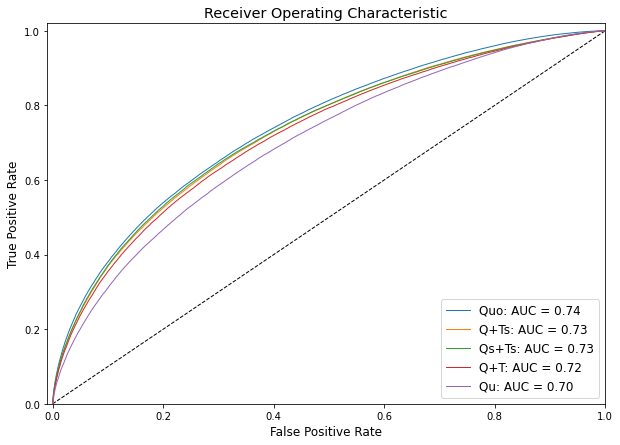

In [165]:
draw_roc_curve(labels, models_to_roc)

In [96]:
import glob

def disp_learn_hist(location, title=None, losslims=None, axis=None, show=True):
    """
    Purpose : Plot the loss and accuracy history for a training session
    
    Args: 
        location    ... output directory containing log files
        title       ... the title for the plot
        losslims    ... sets bound on y axis of loss
        axis        ... axis to plot on
        show        ... if true then display figure, otherwise return figure
    """
    val_log=location + '/log_val.csv'
    val_log_df  = pd.read_csv(val_log)

    train_log_df = get_aggregated_train_data(location)

    if axis is None:
        fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
    else:
        ax1 = axis
    
    line11 = ax1.plot(train_log_df.epoch, train_log_df.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
    line12 = ax1.plot(val_log_df.epoch, val_log_df.loss, marker='o', markersize=3, linestyle='', label='Validation loss', color='blue')

    if losslims is not None:
        ax1.set_ylim(losslims[0],losslims[1])
    
    ax2 = ax1.twinx()
    line21 = ax2.plot(train_log_df.epoch, train_log_df.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
    line22 = ax2.plot(val_log_df.epoch, val_log_df.accuracy, marker='o', markersize=3, linestyle='', label='Validation accuracy', color='red')

    ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
    ax1.tick_params('x',colors='black',labelsize=18)
    ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
    ax1.tick_params('y',colors='b',labelsize=18)
    
    ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
    ax2.tick_params('y',colors='r',labelsize=18)
    ax2.set_ylim(0.,1.05)
    ax2.set_yticks(np.arange(0,1.1,0.1))

    # added these four lines
    lines  = line11 + line12 + line21 + line22
    labels = [l.get_label() for l in lines]
    leg    = ax2.legend(lines, labels, fontsize=14, loc=3, numpoints=1)
    leg_frame = leg.get_frame()
    leg_frame.set_facecolor('white')

    if title is not None:
        ax1.set_title(title, fontsize=20)

    if show:
        plt.grid()
        plt.show()
        return
    
    if axis is None:
        return fig
    
def get_aggregated_train_data(location):
    """
    Aggregate training logs from all processes into a single set of data

    Args:
        location    ... path to outputs directory containing training logs

    Returns: pandas dataframe containing aggregated data
    """
    # get all training data files
    base_log_path = location + '/log_train_[0-9]*.csv'
    log_paths = glob.glob(base_log_path)

    print("Found training logs: ", log_paths)
    
    log_dfs = []
    for log_path in log_paths:
        log_dfs.append(pd.read_csv(log_path))
        log_dfs.append(pd.read_csv(log_path))
    
    # combine all files into one dataframe
    train_log_df = pd.DataFrame(0, index=np.arange(len(log_dfs[0])), columns=log_dfs[0].columns)
    for idx, df_vals in enumerate(zip(*[log_df.values for log_df in log_dfs])):
        iteration = df_vals[0][0]
        epoch = df_vals[0][1]
        loss = sum([df_val[2] for df_val in df_vals]) / len(df_vals)
        accuracy = sum([df_val[3] for df_val in df_vals]) / len(df_vals)

        output_df_vals = (iteration, epoch, loss, accuracy)
        train_log_df.iloc[idx] = output_df_vals

    return train_log_df

Found training logs:  ['./data/Qs+Ts/log_train_0.csv']


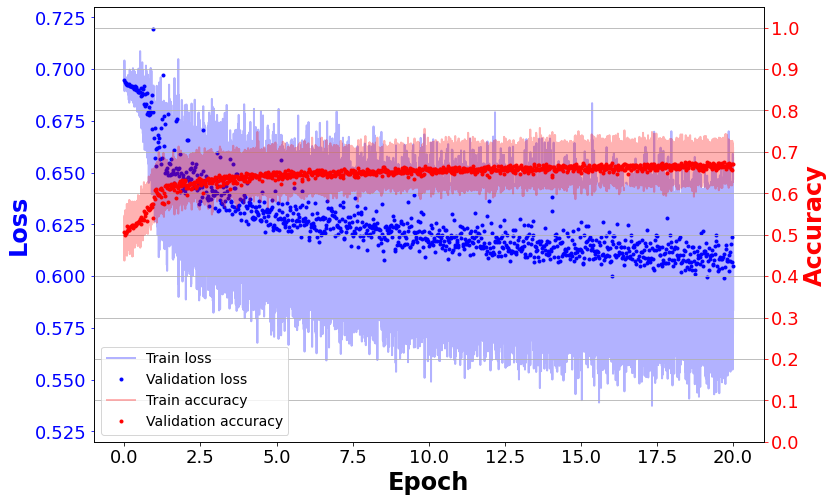

In [97]:
disp_learn_hist(base_path+'Qs+Ts', losslims=(0.52, 0.73))

Found training logs:  ['./data/Q+T/log_train_0.csv']


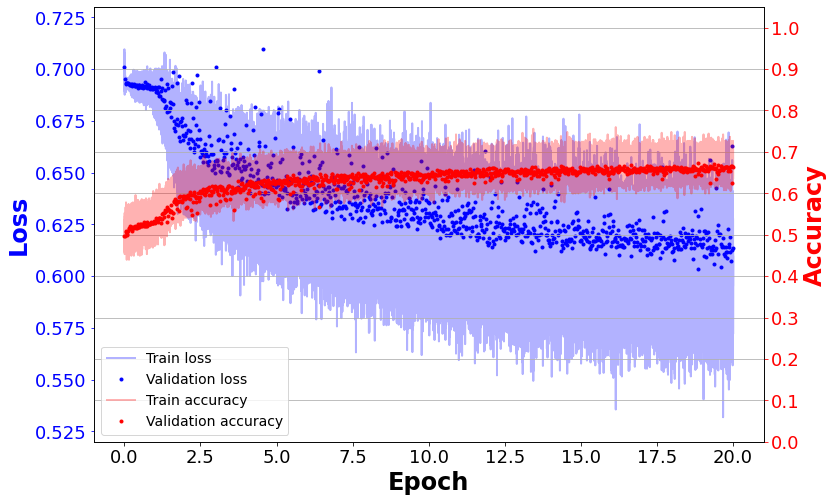

In [98]:
disp_learn_hist(base_path+'Q+T', losslims=(0.52, 0.73))

Found training logs:  ['./data/Q+Ts/log_train_0.csv']


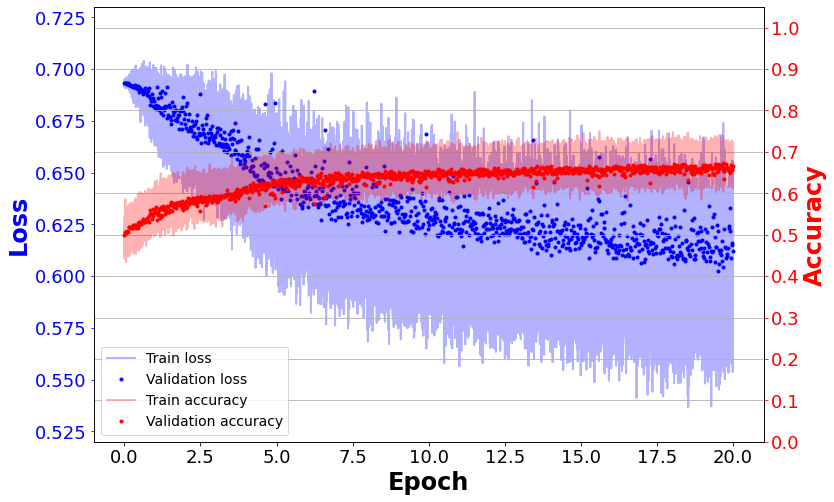

In [99]:
disp_learn_hist(base_path+'Q+Ts', losslims=(0.52, 0.73))